<a href="https://colab.research.google.com/github/panghanwu/tibame_project/blob/main/gender_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config Model



In [2]:
from tensorflow.keras.applications import ResNet50

resnet50 = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=2
)

resnet50.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense
)

gender_model = Sequential()
gender_model.add(resnet50)
gender_model.add(GlobalAveragePooling2D())
gender_model.add(Dense(2, activation='softmax'))

# weights = 'drive/My Drive/Colab Notebooks/tibame_project/gender_identifying/gender_resnet50_haar.h5'
# gender_model.set_weights(weights)

gender_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


# Load Dataset

In [4]:
"""List"""
import pandas as pd

face_list = pd.read_csv('drive/My Drive/Colab Notebooks/tibame_project/gender_identifying/face_data_train.csv')
face_list

,File Name,Gender,Race,Age
0,49_1_0_20170117160609295.jpg,Female,White,49
1,28_1_0_20170117180702119.jpg,Female,White,28
2,26_1_0_20170116184526152.jpg,Female,White,26
3,64_0_0_20170111204813415.jpg,Male,White,64
4,30_0_0_20170117131018041.jpg,Male,White,30
...,...,...,...,...
9489,63_1_4_20170110180156105.jpg,Female,Others,63
9490,69_1_4_20170110141201824.jpg,Female,Others,69
9491,18_1_4_20170109212430115.jpg,Female,Others,18
9492,19_1_4_20170109192214298.jpg,Female,Others,19


In [5]:
"""Target"""
import numpy as np

def gender2code(d):
    if d == 'Female':
        return 0
    else:
        return 1

# categories to number
face_cate = face_list['Gender'].apply(gender2code)

# to numpy array
face_cate = face_cate.to_numpy()

# label
gender = {
    0:'Female',
    1:'Male'
}

print(face_cate.shape)

(9494,)


In [6]:
"""Image"""

npy_name = 'face_crop_mtcnn.npy'
face_img = np.load('drive/My Drive/Colab Notebooks/tibame_project/gender_identifying/'+
                   npy_name)
face_img.shape

(9494, 224, 224, 3)

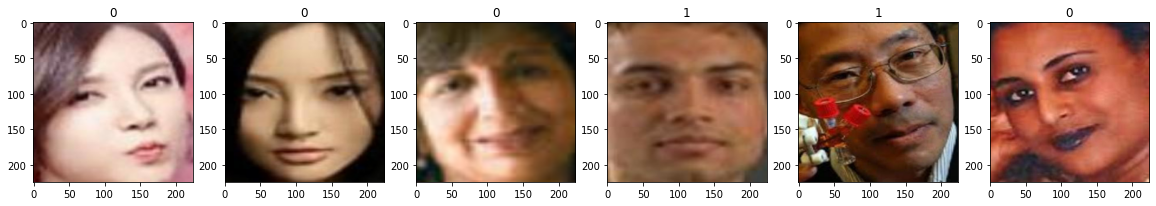

In [7]:
import matplotlib.pyplot as plt
import random

rid = random.choices(np.arange(face_img.shape[0]), k=25)

plt.figure(figsize=(20,6))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(face_img[rid[i]])
    plt.title(face_cate[rid[i]])

plt.show()

In [8]:
"""Split to train & val"""
from sklearn.model_selection import train_test_split

x_tra, x_val, y_tra, y_val = train_test_split(face_img, face_cate, test_size=0.1)
print(x_tra.shape, x_val.shape, y_tra.shape, y_val.shape)

(8544, 224, 224, 3) (950, 224, 224, 3) (8544,) (950,)


In [9]:
"""Data generator"""
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.utils import to_categorical
import imgaug.augmenters as iaa
import imgaug as ia

# augmentation
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(-45, 45),
        mode=ia.ALL, # edge, reflect, symmetric, warp, constant
        shear=(-16,16)
    )
])

def data_generator(x_input, y_input, batch_size, aug=True):
    n = x_input.shape[0]
    i = 0
    
    while True:
        image_data = []
        class_data = []
        
        for b in range(batch_size):
            if i==0:
                rid = np.arange(n)
                np.random.shuffle(rid)
            
            img = x_input[rid[i]]
            
            # img aug
            if aug:
                img = seq.augment_image(img)
            
            # caffe normalization
            img = preprocess_input(img)
            image_data.append(img)

            cls = y_input[rid[i]]
            # one hot encoding
            cls = to_categorical(cls, num_classes=2)
            class_data.append(cls)

            i = (i+1) % n
        
        image_data = np.array(image_data)
        class_data = np.array(class_data)

        yield image_data, class_data


# Training

In [10]:
BATCH_SIZE = 32

data_gen_tra = data_generator(x_tra, y_tra, BATCH_SIZE)
data_gen_val = data_generator(x_val, y_val, BATCH_SIZE, aug=False)

In [11]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

gender_model.compile(loss=CategoricalCrossentropy(),
                     optimizer=Adam(),
                     metrics=['accuracy'])

weights = 'drive/My Drive/Colab Notebooks/tibame_project/gender_identifying/gender_resnet50_haar.h5'

callbacks = [
    ModelCheckpoint(weights, save_best_only=True),
    EarlyStopping(patience=6, restore_best_weights=True)
]

gender_model.fit_generator(
    data_gen_tra,
    epochs=64,
    steps_per_epoch=x_tra.shape[0]//BATCH_SIZE,
    callbacks=callbacks,
    validation_data=data_gen_val,
    validation_steps=x_val.shape[0]//BATCH_SIZE
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/64
267/267 [==============================] - 93s 348ms/step - loss: 0.5814 - accuracy: 0.7363 - val_loss: 3.3080 - val_accuracy: 0.5636
Epoch 2/64
267/267 [==============================] - 96s 359ms/step - loss: 0.3480 - accuracy: 0.8594 - val_loss: 1.0043 - val_accuracy: 0.7371
Epoch 3/64
267/267 [==============================] - 98s 367ms/step - loss: 0.3082 - accuracy: 0.8757 - val_loss: 0.4635 - val_accuracy: 0.8341
Epoch 4/64
267/267 [==============================] - 98s 366ms/step - loss: 0.2815 - accuracy: 0.8862 - val_loss: 0.2714 - val_accuracy: 0.9159
Epoch 5/64
267/267 [==============================] - 95s 355ms/step - loss: 0.2683 - accuracy: 0.8924 - val_loss: 0.4412 - val_accuracy: 0.8653
Epoch 6/64
267/267 [==============================] - 95s 355ms/step - loss: 0.2472 - accuracy: 0.9034 - val_loss: 0.5971 - val_accuracy: 0.7705
Epoch 7/64
267/267 [==============================] - 

In [12]:
model_name = 'gender_resnet50_mtcnn'
resnet50.save('drive/My Drive/Colab Notebooks/tibame_project/gender_identifying/'+model_name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/tibame_project/gender_identifying/gender_resnet50_mtcnn/assets


In [13]:
!pip install mtcnn
from mtcnn import MTCNN

detector = MTCNN()

     |████████████████████████████████| 2.3MB 8.3MB/s 


Execution time: 3.5272326469421387


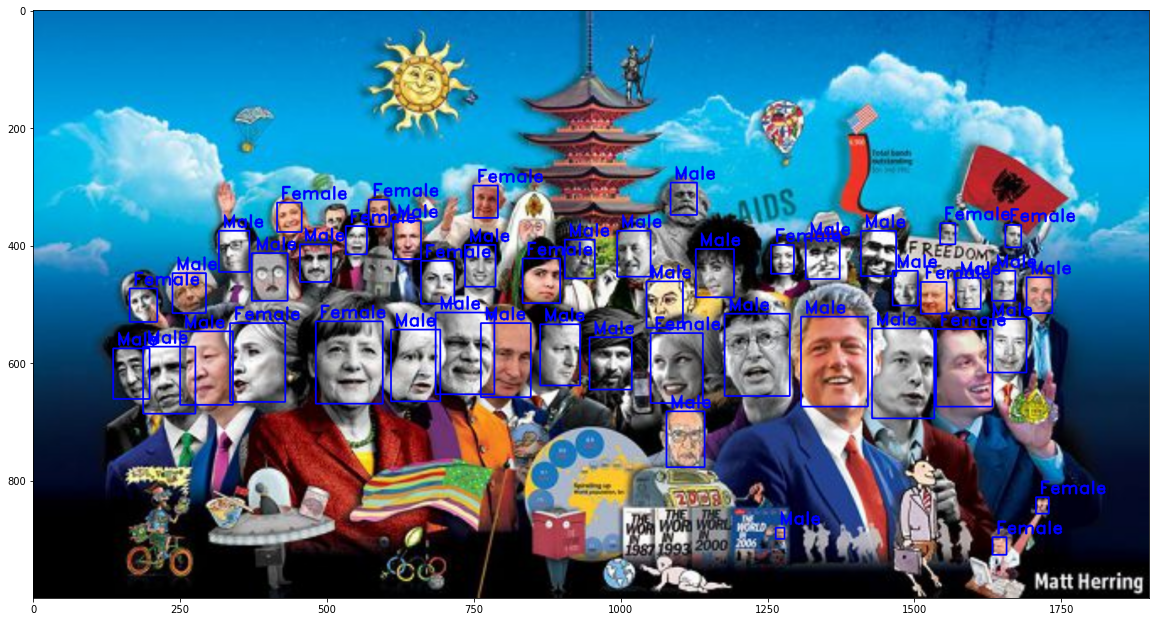

In [53]:
"""Test"""
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import cv2
import time

# test image
# url = 'https://d32kak7w9u5ewj.cloudfront.net/media/image/2016/03/bdf4d5ed8875475db1c12451296b6ac8.jpg'
url = 'https://cc.tvbs.com.tw/news3.0/tvbs/news/politics/images/2015/11/18/CTmficMUkAAMY4p.jpg'
urlretrieve(url, 'image.jpg')
img = cv2.imread('image.jpg', 1)
img = cv2.resize(img, (1900,1000))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

start = time.time()
# face detection
bbox = detector.detect_faces(img)
result = img.copy()

if bbox != []:
    # crop if success
    area = 0
    for b in bbox:
        x, y, w, h = b['box']
        cv2.rectangle(result, (x,y), (x+w,y+h), (0,0,255), 2)

        face_img = img[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (224,224))
        face_img = preprocess_input(face_img)
        face_img = face_img.reshape(1, 224, 224, 3)

        # gender identifying
        g = np.argmax(gender_model.predict(face_img))
        tag = gender[g]
        cv2.putText(result, tag, (x + 6, y - 6), 
                    cv2.FONT_HERSHEY_DUPLEX, 1, 
                    (0, 0 , 255), 2)

end = time.time()

plt.figure(figsize=(20,12))
plt.imshow(result)
print('Execution time:', end-start)